In [1]:
import os
import sys
import re

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
sys.path.insert(0, '../src')

from features import *

In [3]:
features = [
  "download_avg", 
  "download_std",
  "peak_avg",
  "peak_std",
  "peak_amount", 
  "seconds_per_peak", 
  "prominence_std",
  "max_prominence",
  "rolling_cv" 
]

size = 300

In [4]:
%%time
one_four_dir = ['../data/144p/' + fp for fp in os.listdir('../data/144p')]
two_four_dir = ['../data/240p/' + fp for fp in os.listdir('../data/240p')]
three_six_dir = ['../data/360p/' + fp for fp in os.listdir('../data/360p')]
four_eight_dir = ['../data/480p/' + fp for fp in os.listdir('../data/480p')]
seven_two_dir = ['../data/720p/' + fp for fp in os.listdir('../data/720p')]
ten_eight_dir = ['../data/1080p/' + fp for fp in os.listdir('../data/1080p')]

feat_144 = np.vstack(([create_features(fp, size, 5, 1, .5) for fp in one_four_dir]))
feat_240 = np.vstack(([create_features(fp, size, 5, 1, .5) for fp in two_four_dir]))
feat_360 = np.vstack(([create_features(fp, size, 5, 1, .5) for fp in three_six_dir]))
feat_480 = np.vstack(([create_features(fp, size, 5, 1, .5) for fp in four_eight_dir]))
feat_720 = np.vstack(([create_features(fp, size, 5, 1, .5) for fp in seven_two_dir]))
feat_1080 = np.vstack(([create_features(fp, size, 5, 1, .5) for fp in ten_eight_dir]))

Wall time: 55.8 s


In [5]:
feat_df_144 = pd.DataFrame(columns=features, data=feat_144)
feat_df_144['resolution'] = 144

feat_df_240 = pd.DataFrame(columns=features, data=feat_240)
feat_df_240['resolution'] = 240

feat_df_360 = pd.DataFrame(columns=features, data=feat_360)
feat_df_360['resolution'] = 360

feat_df_480 = pd.DataFrame(columns=features, data=feat_480)
feat_df_480['resolution'] = 480

feat_df_720 = pd.DataFrame(columns=features, data=feat_720)
feat_df_720['resolution'] = 720

feat_df_1080 = pd.DataFrame(columns=features, data=feat_1080)
feat_df_1080['resolution'] = 1080

## Baseline Model - 3 Resolutions

We started with a basic model with 3 even spaced resolutions: 240p, 480p, and 1080p. Our intention was to ensure that our features were sufficient enough to define distinctions between fairly spaced classes before attempting more defined predictions. Through some experimentation, we decided to move forward with a Random Forest model. Random Forest is better attuned for multiclassification situations like ours and its inherent randomness of feature selection will overcome the correlation within our features. Random Forest is also an ideal algorithm since we don't need to scale (standardize or normalize) our data. This is particularly useful as some of our spectral features are noticeably larger than the time domain features (spikes, thresholding).

In [6]:
training = pd.concat((
  feat_df_240,
  feat_df_480,
  feat_df_1080
))

training.shape

(228, 10)

In [7]:
X, y = training.drop(columns=['resolution']), training['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42,  stratify=training['resolution'])

clf = RandomForestClassifier(n_estimators = 10, max_depth = 10, criterion = 'entropy', min_samples_split = 3, random_state = 42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Random Forest - Baseline Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F1 Score: ' + str(np.round(f1_score(y_test, y_pred, average=None), 2)))
pd.crosstab(y_test, y_pred, rownames=['Actual Resolution'], colnames=['Predicted Resolution'], normalize='index')

Random Forest - Baseline Accuracy: 0.9122807017543859
F1 Score: [1.   0.87 0.87]


Predicted Resolution,240,480,1080
Actual Resolution,,,
240,1.0,0.000000,0.000000
480,0.0,0.850000,0.150000
1080,0.0,0.105263,0.894737


In [ ]:
import pickle
pkl_filename = "baseline_model.pkl"
with open(pkl_filename, 'wb') as f:
    pickle.dump(clf, f)

In [8]:
pd.crosstab(y_test, y_pred, rownames=['Actual Resolution'], colnames=['Predicted Resolution'])

Predicted Resolution,240,480,1080
Actual Resolution,,,
240,18,0,0
480,0,17,3
1080,0,2,17


Text(0, 0.5, 'Features')

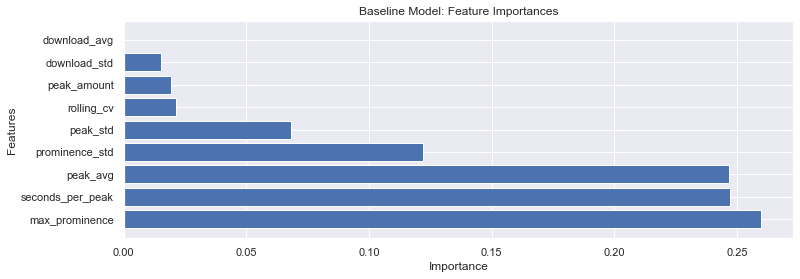

In [9]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

sns.set(rc={'figure.figsize':(12,4)})
plt.barh(np.array(features)[indices],importances[indices])
plt.title('Baseline Model: Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

## Expanded Model - 6 Resolutions

In [ ]:
training = pd.concat((
  feat_df_144,
  feat_df_240,
  feat_df_360,
  feat_df_480,
  feat_df_720,
  feat_df_1080
))

training.shape

In [ ]:
X, y = training.drop(columns=['resolution']), training['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42,  stratify=training['resolution'])

clf = RandomForestClassifier(n_estimators = 10, max_depth = 10, criterion = 'entropy', min_samples_split = 2, random_state = 42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Random Forest - Expanded Model Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F1 Score: ' + str(np.round(f1_score(y_test, y_pred, average=None), 2)))
(pd.crosstab(y_test, y_pred, rownames=['Actual Resolution'], colnames=['Predicted Resolution']))

In [ ]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

sns.set(rc={'figure.figsize':(10,7)})
plt.barh(np.array(features)[indices], importances[indices])
plt.title('Expanded Model - 5 Resolutions: Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

## Expanded Model - Binned Resolutions

In [12]:
feat_df_144 = pd.DataFrame(columns=features, data=feat_144)
feat_df_144['resolution'] = "low"

feat_df_240 = pd.DataFrame(columns=features, data=feat_240)
feat_df_240['resolution'] = "low"

feat_df_360 = pd.DataFrame(columns=features, data=feat_360)
feat_df_360['resolution'] = "medium"

feat_df_480 = pd.DataFrame(columns=features, data=feat_480)
feat_df_480['resolution'] = "medium"

feat_df_720 = pd.DataFrame(columns=features, data=feat_720)
feat_df_720['resolution'] = "high"

feat_df_1080 = pd.DataFrame(columns=features, data=feat_1080)
feat_df_1080['resolution'] = "high"

training = pd.concat((
  feat_df_144,
  feat_df_240,
  feat_df_360,
  feat_df_480,
  feat_df_720,
  feat_df_1080
))

training.shape

(441, 10)

In [13]:
X, y = training.drop(columns=['resolution']), training['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42,  stratify=training['resolution'])

clf = RandomForestClassifier(n_estimators = 15, max_depth = 10, criterion = 'entropy', min_samples_split = 3, random_state = 42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Random Forest - Binned Resolutions Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F1 Score: ' + str(np.round(f1_score(y_test, y_pred, average=None), 2)))
(pd.crosstab(y_test, y_pred, rownames=['Actual Resolution'], colnames=['Predicted Resolution'], normalize='index'))

Random Forest - Binned Resolutions Accuracy: 0.8918918918918919
F1 Score: [0.89 0.94 0.85]


Predicted Resolution,high,low,medium
Actual Resolution,,,
high,0.871795,0.000000,0.128205
low,0.000000,0.939394,0.060606
medium,0.076923,0.051282,0.871795


In [14]:
(pd.crosstab(y_test, y_pred, rownames=['Actual Resolution'], colnames=['Predicted Resolution']))

Predicted Resolution,high,low,medium
Actual Resolution,,,
high,34,0,5
low,0,31,2
medium,3,2,34


Text(0, 0.5, 'Features')

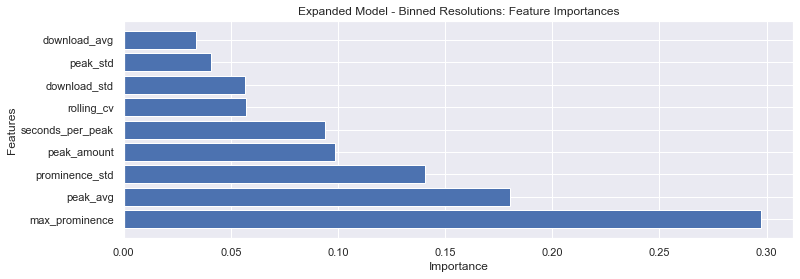

In [15]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

top_5 = np.array(features)[indices[:5]]

sns.set(rc={'figure.figsize':(12,4)})
plt.barh(np.array(features)[indices], importances[indices])
plt.title('Expanded Model - Binned Resolutions: Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

In [17]:
import pickle
pkl_filename = "final_model.pkl"
with open(pkl_filename, 'wb') as f:
    pickle.dump(clf, f)

## Top 5 Features Only

In [ ]:
X, y = training[top_5], training['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42,  stratify=training['resolution'])

clf = RandomForestClassifier(n_estimators = 15, max_depth = 10, criterion = 'entropy', min_samples_split = 3, random_state = 42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Random Forest - Binned Resolutions Accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('F1 Score: ' + str(np.round(f1_score(y_test, y_pred, average=None), 2)))
(pd.crosstab(y_test, y_pred, rownames=['Actual Resolution'], colnames=['Predicted Resolution']))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)